# Лабораторная работа №5 по курсу "Интеллектуальный анализ данных".

Лабораторная работа №5 "Градиентный бустинг с Catboost".<br>
Выполнил студент группы 6133-010402 Мелешенко Иван.

# [Задание на лабораторную работу](https://github.com/kvvik/DS_SamU/blob/main/tasks/lab_5_catboost_groupNumber_SecondName.ipynb)

## ***Задание 1.***<br>Подобрать набор данных для классификации (количество классов не имеет значения) и регрессии.<br>
Важно наличие числовых и категориальных признаков в данных.<br>
Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. 

## ***Задание 2.***<br>Применить классификатор CatBoostClassifier к набору данных.<br>
Обратите внимание, что catboost умеет работать с категориальными признаками (параметр cat_features - список индексов категориальных признаков), поэтому использование pd.factorize / pd.get_dummies здесь лишнее.

* Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss.
* Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо).
* В случае бинарной классификации на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

## ***Задание 3.***<br> Применить регрессию CatBoostRegressor к набору данных для регрессии.<br>
Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации. Обратите внимание, что в задаче восстановления регрессии целевая переменная имеет непрерывные значения.

# Выполнение заданий работы

## Этап 0. Подготовка данных.

### Установкка catboost

In [ ]:
! pip install catboost shap ipywidgets
! jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 76.1 MB 57 kB/s 
     |████████████████████████████████| 564 kB 43.0 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


### Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

import warnings
import sys  
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Подключение Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Описание [Dataset](http://archive.ics.uci.edu/ml/datasets/Automobile)

In [ ]:
fp = "/content/drive/MyDrive/datasets/imports-85_inf.txt" #вытащим описание датасета
with open(fp) as file_handler:
    for line in file_handler:
        print(line)

1. Title: 1985 Auto Imports Database



2. Source Information:

   -- Creator/Donor: Jeffrey C. Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)

   -- Date: 19 May 1987

   -- Sources:

     1) 1985 Model Import Car and Truck Specifications, 1985 Ward's

        Automotive Yearbook.

     2) Personal Auto Manuals, Insurance Services Office, 160 Water

        Street, New York, NY 10038 

     3) Insurance Collision Report, Insurance Institute for Highway

        Safety, Watergate 600, Washington, DC 20037



3. Past Usage:

   -- Kibler,~D., Aha,~D.~W., \& Albert,~M. (1989).  Instance-based prediction

      of real-valued attributes.  {\it Computational Intelligence}, {\it 5},

      51--57.

	 -- Predicted price of car using all numeric and Boolean attributes

	 -- Method: an instance-based learning (IBL) algorithm derived from a

	    localized k-nearest neighbor algorithm.  Compared with a

	    linear regression prediction...so all instances

	    with missing attribute values were

### Загрузка Dataset-а

In [ ]:
machframe = pd.read_csv("/content/drive/MyDrive/datasets/imports-85.txt",names=['symboling', 'normalized-losses', 'make', 'fuel-type', 
                                           'aspiration', 'num-of-doors','body-style','drive-wheels',
                                           'engine-location','wheel-base','length','width','height',
                                           'curb-weight','engine-type','num-of-cylinders','engine-size',
                                           'fuel-system','bore','stroke','compression-ratio','horsepower',
                                          'peak-rpm','city-mpg','highway-mpg','price'])

### Просмотр Dataset-а

In [ ]:
machframe.head(10)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
5,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250
6,1,158,audi,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,17710
7,1,?,audi,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,18920
8,1,158,audi,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875
9,0,?,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.40,7.0,160,5500,16,22,?


### Предварительная обработка Dataset-а

In [ ]:
machframe = machframe.drop(machframe[machframe['num-of-doors'] == '?'].index)
machframe = machframe[machframe[:] != '?'].iloc[:,:] #найдем все пропуски в данных и заменим их на медианный
machframe.fillna(machframe.median(),inplace = True)
machframe["num-of-doors"].unique() #проверим бинарный признак

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


array(['two', 'four'], dtype=object)

## Этап 1. CatBoostClassifier

### Разделение признаков

In [ ]:
y = machframe["num-of-doors"]

In [ ]:
X = machframe.drop("num-of-doors", axis=1)

### Задаем колонки категориальных признаков

In [ ]:
cat_features = list([0,2,3,4,5,6,7,13,14,16]) 
print(cat_features)

[0, 2, 3, 4, 5, 6, 7, 13, 14, 16]


### Разбиение на тестовую и обучающую выборки

In [ ]:
import sklearn.model_selection

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state = 0
)

### Построние CatBoostClassifier

In [ ]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function='Logloss', 
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose = False
    
)

print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'Logloss'}


### Определение итерации с наименьшим logloss

In [ ]:
model.get_best_iteration() 

12

### Определение значения на итерации с наименьшим logloss

In [ ]:
model.best_score_ 

{'learn': {'Logloss': 0.02763345062205948},
 'validation': {'Logloss': 0.3717899272574765}}

### Потрим на табличку метрик

In [ ]:
print(sklearn.metrics.classification_report( 
    model.predict(X_test), y_test, target_names=["two", "four"]
) )

              precision    recall  f1-score   support

         two       0.96      0.79      0.86        28
        four       0.79      0.96      0.86        23

    accuracy                           0.86        51
   macro avg       0.87      0.87      0.86        51
weighted avg       0.88      0.86      0.86        51



В сравнении с алгоритмами лес и дерево, которые имели долю правильных ответов в 0.82, catboostclassifier дал долю правильных ответов в 0.88

## Этап 2. CatBoostRegressor

### Запишем в лист все категориальные колонки

In [ ]:
mach = machframe 
col = list(['make','body-style','drive-wheels', 
            'fuel-system','engine-type','fuel-type',
           'aspiration','num-of-doors','engine-location','num-of-cylinders'])

In [ ]:
for num in col: 
    mach[num] = pd.factorize(machframe[num])[0]

### Произведем разбиение признаков

In [ ]:
y_r = mach["num-of-doors"]
X_r = mach.drop("num-of-doors", axis=1)

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = sklearn.model_selection.train_test_split(
    X_r, y_r, random_state = 0
)

### Выведем номера итераций с значениями метрик (MAE и MSE) для наилучших итераций.

#### Метрика MSE

##### Создаем и передаем выборку КБ

In [ ]:
model_r = CatBoostRegressor(iterations=500, learning_rate=0.1, use_best_model=True, loss_function = 'RMSE') 
model_r.fit(X_train_r, y_train_r, verbose=False, eval_set=(X_test_r, y_test_r))

##### Наилучшая итерация

In [ ]:
model_r.get_best_iteration() 

98

##### Подсчитаем метрики

In [ ]:
print('MAE: ' + str(sklearn.metrics.mean_absolute_error(y_test_r, model_r.predict(data=X_test_r))))
print('MSE: ' + str(sklearn.metrics.mean_squared_error(y_test_r, model_r.predict(data=X_test_r))))

MAE: 0.2319734838190081
MSE: 0.11140620857227031


#### Метрика MAE

##### Создаем и передаем выборку КБ

In [ ]:
model_r = CatBoostRegressor(iterations=500, learning_rate=0.1, use_best_model=True, loss_function = 'MAE') 
model_r.fit(X_train_r, y_train_r, verbose=False, eval_set=(X_test_r, y_test_r))

##### Определим наилучшую итерация

In [ ]:
model_r.get_best_iteration() 

49

##### Подсчитаем метрики

In [ ]:
print('MAE: ' + str(sklearn.metrics.mean_absolute_error(y_test_r, model_r.predict(data=X_test_r))))
print('MSE: ' + str(sklearn.metrics.mean_squared_error(y_test_r, model_r.predict(data=X_test_r))))

MAE: 0.20442635753395877
MSE: 0.11933934835570116


## Этап 3. График для CatBoostClassifier

Для бинарного классификатора на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

In [ ]:
from catboost.utils import get_roc_curve
import sklearn.metrics

In [ ]:
# наподобие класса с конструктором, чтоб передавать удобнее было
eval_pool = Pool(X_test, y_test, cat_features=cat_features) 
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

#ROC AUC
print('ROC-AUC: ' + str(roc_auc)) 

ROC-AUC: 0.937888198757764


### Построение ROC-кривой

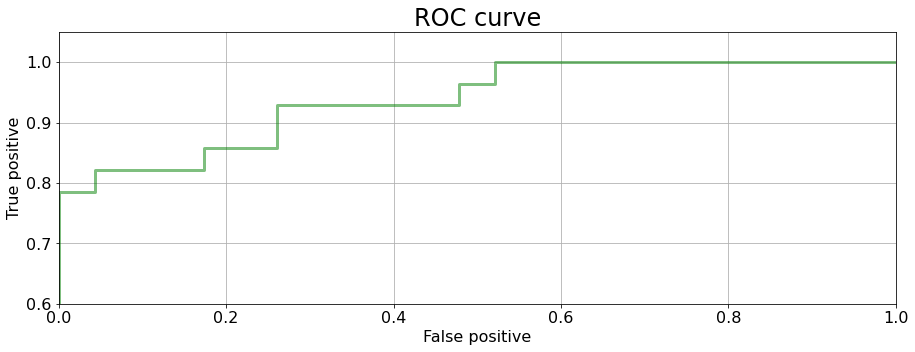

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(fpr, tpr, color='green', lw=3, label='ROC curve (area = %0.3f)' % roc_auc, alpha=0.5)

 #настроим область отображения, размеры шрифта, подписи и тд
plt.xlim([0.0, 1.0])
plt.ylim([0.6, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False positive', fontsize=16)
plt.ylabel('True positive', fontsize=16)
plt.title('ROC curve', fontsize=24)
plt.show()

### Построение PRC-кривой

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


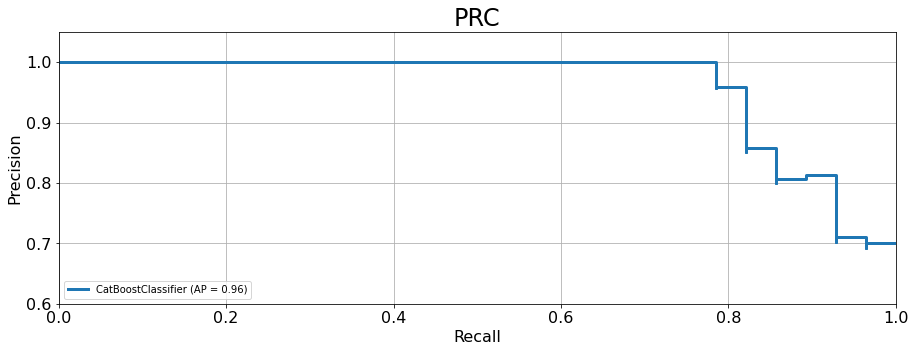

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))


sklearn.metrics.plot_precision_recall_curve(model, X_test, y_test, ax=ax, lw = 3)

plt.xlim([0.0, 1.0])
plt.ylim([0.6, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('PRC', fontsize=24)

plt.show()

In [ ]:
#RPC AUC
s = sklearn.metrics.average_precision_score(pd.factorize(y_test)[0], model.predict_proba(X_test)[:,0]) 
print('RPC-AUC: ' + str(s))

RPC-AUC: 0.9213305046695979
